# 1. Setup and Imports

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

!pip install torch==2.0.1 torchvision==0.15.2 tqdm==4.65.0 matplotlib==3.7.1 numpy==1.23.5 torchmetrics==0.11.4
# packages I missed importing
!pip install torch-fidelity
!pip install torchmetrics[image]
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torch.cuda.amp import GradScaler, autocast
import glob
import shutil
import copy

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

try:
    device = xm.xla_device()  # TPU
except:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.9 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.6 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 94.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.9 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 88.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
!nvidia-smi

Mon Mar 31 16:55:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   28C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Memory-Efficient Self-Attention and UNet Components


In [28]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.key = nn.Conv2d(channels, channels, 1)
        self.query = nn.Conv2d(channels, channels, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        batch_size, c, h, w = x.shape
        
        # Adaptive downsampling for large feature maps to save memory
        if h > 32:  # Adjust threshold based on your GPU memory
            downsample_factor = max(1, h // 16)
            x_downsampled = F.avg_pool2d(x, downsample_factor)
            h_d, w_d = x_downsampled.shape[2:]
            
            # Project to key, query, value
            key = self.key(x_downsampled).view(batch_size, c, h_d * w_d)
            query = self.query(x_downsampled).view(batch_size, c, h_d * w_d).permute(0, 2, 1)
            value = self.value(x_downsampled).view(batch_size, c, h_d * w_d)
            
            # Memory-efficient attention computation
            attention = F.softmax(torch.bmm(query, key), dim=-1)
            attention_applied = torch.bmm(value, attention.permute(0, 2, 1))
            attention_applied = attention_applied.view(batch_size, c, h_d, w_d)
            
            # Upsample attention results back to original size
            attention_upsampled = F.interpolate(attention_applied, size=(h, w), mode='bilinear', align_corners=False)
            return x + self.gamma * attention_upsampled
        else:
            # For smaller feature maps, use standard self-attention
            key = self.key(x).view(batch_size, c, h * w)
            query = self.query(x).view(batch_size, c, h * w).permute(0, 2, 1)
            value = self.value(x).view(batch_size, c, h * w)
            
            attention = F.softmax(torch.bmm(query, key), dim=-1)
            attention_applied = torch.bmm(value, attention.permute(0, 2, 1))
            attention_applied = attention_applied.view(batch_size, c, h, w)
            
            return x + self.gamma * attention_applied


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(DoubleConv, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )
        
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, emb_dim=256):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels + skip_channels, in_channels, residual=False),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


# 2. UNet Architecture (Unconditional and Conditional)


In [37]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device="cuda"):  # Increase time embedding dim
        super(UNet, self).__init__()
        self.device = device
        self.time_dim = time_dim

        # Increase initial feature maps for better representation
        self.inc = DoubleConv(c_in, 128)  # Increased from 64
        
        # Enhanced downsampling path
        self.down1 = Down(128, 256, emb_dim=time_dim)  # Increased capacity
        self.sa1 = SelfAttention(256)
        self.down2 = Down(256, 512, emb_dim=time_dim)  # Increased capacity
        self.sa2 = SelfAttention(512)
        self.down3 = Down(512, 512, emb_dim=time_dim)
        self.sa3 = SelfAttention(512)
        
        # Enhanced bottleneck
        self.bot1 = DoubleConv(512, 1024)  # Increased capacity
        self.bot2 = DoubleConv(1024, 1024)
        self.bot3 = DoubleConv(1024, 512)
        
        # Upsampling
        self.up1 = Up(512, 512, 128, emb_dim=time_dim)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(128, 256, 64, emb_dim=time_dim)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(64, 128, 64, emb_dim=time_dim)
        self.sa6 = SelfAttention(64)
      
        # Final projection
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        """
        Create positional encoding for timesteps
        """
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        # Time embedding
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # UNet architecture
        x1 = self.inc(x)
        
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        
        output = self.outc(x)
        
        return output


class ConditionalUNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=128, num_classes=None, device="cuda"):
        super(ConditionalUNet, self).__init__()
        self.device = device
        self.time_dim = time_dim
        self.num_classes = num_classes

        # Class embedding if conditional
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # Initial projection
        self.inc = DoubleConv(c_in, 64)
        
        # Downsampling
        self.down1 = Down(64, 128, emb_dim=time_dim)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256, emb_dim=time_dim)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256, emb_dim=time_dim)
        self.sa3 = SelfAttention(256)
        
        # Bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        # Upsampling
        self.up1 = Up(512, 512, 128, emb_dim=time_dim)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(128, 256, 64, emb_dim=time_dim)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(64, 128, 64, emb_dim=time_dim)
        self.sa6 = SelfAttention(64)     
        
        # Final projection
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        """
        Create positional encoding for timesteps
        """
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y=None):
        # Time embedding + optional class embedding
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Add conditional embedding if class label is provided
        if y is not None and self.num_classes is not None:
            t = t + self.label_emb(y)
        
        # UNet architecture (same as unconditional)
        x1 = self.inc(x)
        
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        
        output = self.outc(x)
        
        return output

# 3. Diffusion Process Implementation


In [38]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        """
        Initialize the diffusion process
        
        Args:
            noise_steps: Number of noise steps
            beta_start: Starting noise level
            beta_end: Ending noise level
            img_size: Size of the image
            device: Device to run the model on
        """
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        # Create noise schedule
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """
        Cosine noise schedule (improved from linear)
        Based on improved DDPM paper: https://arxiv.org/abs/2102.09672
        """
        steps = self.noise_steps
        s = 0.008  # Offset parameter
        
        # Create timesteps from 0 to steps
        x = torch.linspace(0, steps, steps + 1)
        
        # Cosine schedule formula
        alphas_cumprod = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize
        
        # Convert alpha cumulative product to betas
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        
        # Clamp for numerical stability
        return torch.clamp(betas, 0.0001, 0.9999)
    
    def noise_images(self, x, t):
        """Add noise to images at timestep t"""
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
    
    def sample_timesteps(self, n):
        """Sample random timesteps for a batch"""
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        """
        Sample n images from the model (unconditional)
        """
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), desc="Sampling"):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    
                # Update x using the reverse diffusion process formula
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        # Convert from [-1, 1] to [0, 1] for visualization
        x = (x.clamp(-1, 1) + 1) / 2
        return x
        
    def sample_ddim(self, model, n, steps=100):
        """
        Sample using DDIM (Denoising Diffusion Implicit Models)
        More efficient sampling with fewer steps
        """
        model.eval()
        with torch.no_grad():
            # Start from random noise
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            
            # Select subset of timesteps for faster sampling
            step_size = self.noise_steps // steps
            timesteps = list(range(0, self.noise_steps, step_size))
            timesteps.append(self.noise_steps-1)  # Make sure we include the last step
            timesteps = sorted(list(set(timesteps)), reverse=True)
            
            for i in tqdm(range(len(timesteps)-1), desc="DDIM Sampling"):
                t_curr = torch.ones(n, device=self.device) * timesteps[i]
                t_next = torch.ones(n, device=self.device) * timesteps[i+1]
                
                # Current time
                t_curr_int = t_curr.long()
                alpha_curr = self.alpha[t_curr_int][:, None, None, None]
                alpha_hat_curr = self.alpha_hat[t_curr_int][:, None, None, None]
                
                # Next time
                t_next_int = t_next.long()
                alpha_next = self.alpha[t_next_int][:, None, None, None]
                alpha_hat_next = self.alpha_hat[t_next_int][:, None, None, None]
                
                # Predict noise
                predicted_noise = model(x, t_curr_int)
                
                # Predict x_0
                pred_x0 = (x - torch.sqrt(1 - alpha_hat_curr) * predicted_noise) / torch.sqrt(alpha_hat_curr)
                pred_x0 = pred_x0.clamp(-1, 1)
                
                # Get the direction pointing to x_t
                direction = torch.sqrt(1 - alpha_hat_next) * predicted_noise
                
                # Combine to get x_{t-1}
                x = torch.sqrt(alpha_hat_next) * pred_x0 + direction
        
        model.train()
        # Convert from [-1, 1] to [0, 1] for visualization
        x = (x.clamp(-1, 1) + 1) / 2
        return x

    def sample_ddim_with_guidance(self, model, n, steps=100, guidance_scale=3.0, unconditional_conditioning=None):
        """
        Enhanced DDIM sampling with classifier-free guidance for better quality
        
        Args:
            model: UNet model
            n: Number of samples
            steps: Sampling steps 
            guidance_scale: How much to weight the guidance (higher = better quality but less diversity)
        """
        model.eval()
        with torch.no_grad():
            # Start from random noise
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            
            # Select subset of timesteps
            step_size = self.noise_steps // steps
            timesteps = list(range(0, self.noise_steps, step_size))
            timesteps.append(self.noise_steps-1)
            timesteps = sorted(list(set(timesteps)), reverse=True)
            
            for i in tqdm(range(len(timesteps)-1), desc="DDIM Sampling"):
                t_curr = torch.ones(n, device=self.device) * timesteps[i]
                t_next = torch.ones(n, device=self.device) * timesteps[i+1]
                
                # Current time
                t_curr_int = t_curr.long()
                alpha_curr = self.alpha[t_curr_int][:, None, None, None]
                alpha_hat_curr = self.alpha_hat[t_curr_int][:, None, None, None]
                
                # Next time
                t_next_int = t_next.long()
                alpha_next = self.alpha[t_next_int][:, None, None, None]
                alpha_hat_next = self.alpha_hat[t_next_int][:, None, None, None]
                
                # Predict noise and apply classifier-free guidance
                predicted_noise = model(x, t_curr_int)
                
                if guidance_scale > 1.0:
                    # For guidance, predict noise with unconditional embedding (all zeros)
                    if unconditional_conditioning is None:
                        # Create tensor of zeros for unconditional prediction
                        t_emb = t_curr_int.unsqueeze(-1).type(torch.float)
                        t_emb = model.pos_encoding(t_emb, model.time_dim)
                        # Null conditioning by zeroing the time embedding
                        unconditional_noise = model(x, t_curr_int, y=None)
                    else:
                        unconditional_noise = unconditional_conditioning(x, t_curr_int)
                    
                    # Apply guidance formula: predicted = uncond + scale * (cond - uncond)
                    predicted_noise = unconditional_noise + guidance_scale * (predicted_noise - unconditional_noise)
                
                # Predict x_0
                pred_x0 = (x - torch.sqrt(1 - alpha_hat_curr) * predicted_noise) / torch.sqrt(alpha_hat_curr)
                pred_x0 = pred_x0.clamp(-1, 1)
                
                # Get the direction
                direction = torch.sqrt(1 - alpha_hat_next) * predicted_noise
                
                # Combine to get x_{t-1}
                x = torch.sqrt(alpha_hat_next) * pred_x0 + direction
    
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        return x

    def sample_conditional(self, model, n, labels, cfg_scale=3.0):
        """
        Sample n images from the model with classifier-free guidance
        
        Args:
            model: The UNet model
            n: Number of images to sample
            labels: Class labels for conditional generation
            cfg_scale: Classifier-free guidance scale
        """
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), desc="Conditional Sampling"):
                t = (torch.ones(n) * i).long().to(self.device)
                
                # Get conditional and unconditional noise predictions
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    unconditional_predicted_noise = model(x, t, None)
                    predicted_noise = unconditional_predicted_noise + cfg_scale * (predicted_noise - unconditional_predicted_noise)
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    
                # Update x using the reverse diffusion process formula
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        # Convert from [-1, 1] to [0, 1] for visualization
        x = (x.clamp(-1, 1) + 1) / 2
        return x

    def save_images(self, images, path):
        """Save a grid of images"""
        grid = torchvision.utils.make_grid(images)
        ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(ndarr)
        plt.savefig(path)
        plt.close()
        

# 4. Dataset Loading and Preparation


In [39]:
class LensingDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data: numpy array of lens images
            transform: optional transform to apply to the images
        """
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        
        # Convert from numpy array to tensor
        if isinstance(image, np.ndarray):
            # Handle different dimensions of the input data
            if len(image.shape) == 2:  # Single channel
                image = image[..., np.newaxis]
            
            # Convert to float and normalize to range [0, 1] if not already
            if image.dtype == np.uint8:
                image = image.astype(np.float32) / 255.0
            else:
                # Assuming already float, normalize to [0, 1]
                image = (image - image.min()) / (image.max() - image.min() + 1e-8)
                
            # Convert to tensor
            image = torch.from_numpy(image).float()
            
            # Rearrange dimensions to [C, H, W] format if needed
            if image.shape[-1] in [1, 3]:  # If channels dimension is last
                image = image.permute(2, 0, 1)
        
        if self.transform:
            image = self.transform(image)
            
        return image


def load_data():
    """Load the lensing dataset"""
    # For Kaggle environment, check for the dataset path
    kaggle_input_paths = [
        '/kaggle/input/diffusion-dataset/Samples'
    ]
    
    # First try loading a single .npy file
    for path in kaggle_input_paths:
        if os.path.exists(path) and path.endswith('.npy'):
            print(f"Loading dataset from {path}")
            data = np.load(path)
            return data
    
    # If not found, try loading individual .npy files from a directory
    for path in kaggle_input_paths:
        if os.path.exists(path) and os.path.isdir(path):
            print(f"Loading .npy files from {path}")
            files = glob.glob(os.path.join(path, '*.npy'))
            
            if len(files) > 0:
                print(f"Found {len(files)} .npy files")
                
                # Create a progress bar for loading
                from tqdm.auto import tqdm
                
                # Load first file to get dimensions
                sample = np.load(files[0])
                
                # Pre-allocate memory for all images
                if len(sample.shape) == 2:  # Single channel grayscale
                    data = np.zeros((len(files), 1, sample.shape[0], sample.shape[1]), dtype=np.float32)
                    
                    # Load all files with progress bar
                    for i, file in enumerate(tqdm(files, desc="Loading files")):
                        img = np.load(file)
                        data[i, 0] = img
                else:  # Already has channel dimension
                    data = np.zeros((len(files),) + sample.shape, dtype=np.float32)
                    
                    # Load all files with progress bar
                    for i, file in enumerate(tqdm(files, desc="Loading files")):
                        data[i] = np.load(file)
                
                return data
    
    # If not found in Kaggle's predefined locations, allow manual input
    print("Dataset not found in standard locations. Please provide the path:")
    path = input()
    if os.path.exists(path):
        if path.endswith('.npy'):
            data = np.load(path)
        else:
            # Try loading from directory
            files = glob.glob(os.path.join(path, '*.npy'))
            if len(files) > 0:
                print(f"Found {len(files)} .npy files")
                sample = np.load(files[0])
                
                if len(sample.shape) == 2:
                    data = np.zeros((len(files), 1, sample.shape[0], sample.shape[1]), dtype=np.float32)
                    for i, file in enumerate(tqdm(files, desc="Loading files")):
                        img = np.load(file)
                        data[i, 0] = img
                else:
                    data = np.zeros((len(files),) + sample.shape, dtype=np.float32)
                    for i, file in enumerate(tqdm(files, desc="Loading files")):
                        data[i] = np.load(file)
            else:
                raise FileNotFoundError(f"No .npy files found in {path}")
        return data
    else:
        raise FileNotFoundError(f"Could not find dataset at {path}")


def prepare_dataloaders(data, batch_size=16, img_size=64):
    """Prepare dataloaders for training and validation"""
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size), antialias=True),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])
    
    # Create dataset
    dataset = LensingDataset(data, transform=transform)
    
    # Split into training and validation sets (90% train, 10% validation)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader


def visualize_data_samples(data, num_samples=5):
    """Visualize sample images from the dataset"""
    # Choose random samples
    indices = np.random.choice(len(data), num_samples, replace=False)
    samples = data[indices]
    
    # Create a figure
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i, (ax, img) in enumerate(zip(axes, samples)):
        # Normalize for visualization
        if len(img.shape) == 3 and img.shape[0] == 1:  # Channel first
            img = img[0]  # Remove channel dimension for display
            img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
            ax.imshow(img_norm, cmap='viridis')
        elif len(img.shape) == 2:  # No channel
            img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
            ax.imshow(img_norm, cmap='viridis')
        else:  # RGB or multiple channels
            if isinstance(img, np.ndarray) and img.shape[0] == 3:  # Channel first RGB
                img = img.transpose(1, 2, 0)  # Convert to HWC for display
            img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
            ax.imshow(img_norm)
            
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# 5. Training Functions with Mixed Precision and Memory Optimizations


In [40]:
def train_diffusion(model, diffusion, dataloader, optimizer, device, epochs, save_path="models"):
    """
    Train the diffusion model with mixed precision
    """
    # Create directory for checkpoints if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Initialize scaler for mixed precision training
    scaler = GradScaler()
    
    # Initialize best loss
    best_loss = float('inf')
    
    # Loop through epochs
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        
        # Initialize loss
        epoch_loss = 0.0
        
        # Progress bar
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        # Loop through batches
        for batch in progress_bar:
            # Get images
            images = batch.to(device)
            
            # Get batch size
            batch_size = images.shape[0]
            
            # Sample random timesteps
            t = diffusion.sample_timesteps(batch_size).to(device)
            
            # Add noise to images
            x_t, noise = diffusion.noise_images(images, t)
            
            # Use mixed precision
            with autocast():
                # Predict noise
                predicted_noise = model(x_t, t)
                
                # Calculate loss
                loss = F.mse_loss(noise, predicted_noise)
            
            # Backpropagation with gradient scaling
            optimizer.zero_grad(set_to_none=True)  # More memory efficient than zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Update progress bar
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        # Save model if it's the best so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{save_path}/best_model.pt")
        
        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{save_path}/model_epoch_{epoch+1}.pt")
    
    # Save final model
    torch.save(model.state_dict(), f"{save_path}/final_model.pt")
    print(f"Training completed. Best loss: {best_loss:.6f}")
    
    return best_loss


def train_conditional_diffusion(model, diffusion, dataloader, optimizer, device, epochs, save_path="models"):
    """
    Train the conditional diffusion model with mixed precision
    """
    # Create directory for checkpoints if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Initialize scaler for mixed precision training
    scaler = GradScaler()
    
    # Initialize best loss
    best_loss = float('inf')
    
    # Loop through epochs
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        
        # Initialize loss
        epoch_loss = 0.0
        
        # Progress bar
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        # Loop through batches
        for batch, labels in progress_bar:
            # Get images and labels
            images = batch.to(device)
            labels = labels.to(device)
            
            # Get batch size
            batch_size = images.shape[0]
            
            # Sample random timesteps
            t = diffusion.sample_timesteps(batch_size).to(device)
            
            # Add noise to images
            x_t, noise = diffusion.noise_images(images, t)
            
            # With probability 0.1, use None for labels to train unconditional generation
            if random.random() < 0.1:
                labels_to_use = None
            else:
                labels_to_use = labels
                
            # Use mixed precision
            with autocast():
                # Predict noise
                predicted_noise = model(x_t, t, labels_to_use)
                
                # Calculate loss
                loss = F.mse_loss(noise, predicted_noise)
            
            # Backpropagation with gradient scaling
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Update progress bar
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        # Save model if it's the best so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{save_path}/best_conditional_model.pt")
        
        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{save_path}/conditional_model_epoch_{epoch+1}.pt")
    
    # Save final model
    torch.save(model.state_dict(), f"{save_path}/final_conditional_model.pt")
    print(f"Training completed. Best loss: {best_loss:.6f}")
    
    return best_loss


def train_with_gradient_accumulation(model, diffusion, dataloader, optimizer, scheduler=None, device="cuda", 
                                    epochs=50, accumulation_steps=2, save_path="models", 
                                    ema_decay=0.995):  # Add EMA for stability
    """
    Enhanced training with EMA model averaging and better monitoring
    """
    from torch.cuda.amp import GradScaler, autocast
    
    os.makedirs(save_path, exist_ok=True)
    scaler = GradScaler()
    best_loss = float('inf')
    
    # Create EMA model for more stable results
    ema_model = copy.deepcopy(model)
    
    # For monitoring
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        optimizer.zero_grad(set_to_none=True)
        
        for i, batch in enumerate(progress_bar):
            images = batch.to(device)
            batch_size = images.shape[0]
            
            # Timestep sampling strategy: focus more on lower noise levels
            # This improves detail generation
            if epoch > epochs // 2:  # In later epochs
                t = diffusion.sample_timesteps(batch_size).to(device)
                # Bias sampling toward lower noise levels (t values)
                t = (t * torch.rand_like(t.float())).long()
            else:
                t = diffusion.sample_timesteps(batch_size).to(device)
            
            x_t, noise = diffusion.noise_images(images, t)
            
            # Use mixed precision
            with autocast():
                predicted_noise = model(x_t, t)
                # L2 loss works better than L1 for diffusion
                loss = F.mse_loss(noise, predicted_noise)
                loss = loss / accumulation_steps
            
            # Accumulate gradients
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                
                # Update EMA model for more stable results
                with torch.no_grad():
                    for ema_param, model_param in zip(ema_model.parameters(), model.parameters()):
                        ema_param.data = ema_param.data * ema_decay + model_param.data * (1 - ema_decay)
            
            epoch_loss += loss.item() * accumulation_steps
            progress_bar.set_postfix(loss=loss.item() * accumulation_steps)
        
        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()
            
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.7f}")
        
        # Generate samples every 10 epochs to track progress
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                samples = diffusion.sample_ddim(ema_model, 4, steps=50)
                grid = make_grid(samples, nrow=2)
                save_image(grid, f"{save_path}/progress_epoch_{epoch+1}.png")
        
        # Save models
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{save_path}/best_model.pt")
            torch.save(ema_model.state_dict(), f"{save_path}/best_model_ema.pt")
            
    # Save final model and EMA model
    torch.save(model.state_dict(), f"{save_path}/final_model.pt") 
    torch.save(ema_model.state_dict(), f"{save_path}/final_model_ema.pt")
    
    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f"{save_path}/loss_curve.png")
    
    return best_loss, ema_model


# 6. Evaluation Functions


In [41]:
def calculate_fid(real_images, generated_images, device):
    """
    Calculate FID score between real and generated images
    
    Args:
        real_images: Tensor of real images, shape [N, C, H, W], range [0, 1]
        generated_images: Tensor of generated images, shape [N, C, H, W], range [0, 1]
        device: Device to calculate on
    
    Returns:
        FID score
    """
    # Convert to RGB if grayscale
    if real_images.shape[1] == 1:
        real_images = real_images.repeat(1, 3, 1, 1)
    if generated_images.shape[1] == 1:
        generated_images = generated_images.repeat(1, 3, 1, 1)
    
    # Ensure images are in range [0, 1]
    real_images = real_images.clamp(0, 1)
    generated_images = generated_images.clamp(0, 1)
    
    # Convert to range [0, 255] for FID calculation
    real_images = (real_images * 255).type(torch.uint8)
    generated_images = (generated_images * 255).type(torch.uint8)
    
    # Initialize FID metric
    fid = FrechetInceptionDistance(feature=2048).to(device)
    
    # Update with real and generated images
    fid.update(real_images, real=True)
    fid.update(generated_images, real=False)
    
    # Calculate FID
    fid_value = fid.compute()
    
    return fid_value.item()

def calculate_inception_score(generated_images, device):
    """
    Calculate Inception Score for generated images
    
    Args:
        generated_images: Tensor of generated images, shape [N, C, H, W], range [0, 1]
        device: Device to calculate on
    
    Returns:
        Inception Score (mean and std)
    """
    # Convert to RGB if grayscale
    if generated_images.shape[1] == 1:
        generated_images = generated_images.repeat(1, 3, 1, 1)
    
    # Ensure images are in range [0, 1]
    generated_images = generated_images.clamp(0, 1)
    
    # Convert to range [0, 255] for IS calculation
    generated_images = (generated_images * 255).type(torch.uint8)
    
    # Initialize IS metric
    inception = InceptionScore().to(device)
    
    # Update with generated images
    inception.update(generated_images)
    
    # Calculate IS
    mean, std = inception.compute()
    
    return mean.item(), std.item()

def visualize_samples(generated_images, save_path=None, title="Generated Samples"):
    """
    Visualize generated samples
    
    Args:
        generated_images: Tensor of generated images, shape [N, C, H, W], range [0, 1]
        save_path: Path to save visualization, if None, just display
        title: Title for the plot
    """
    # Make a grid of images
    grid = make_grid(generated_images, nrow=8, padding=2, normalize=True)
    
    # Convert to numpy for visualization
    grid_np = grid.permute(1, 2, 0).cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(15, 15))
    
    # Display grayscale or color images accordingly
    if grid_np.shape[2] == 1:
        plt.imshow(grid_np[:, :, 0], cmap='viridis')
    else:
        plt.imshow(grid_np)
    
    plt.title(title, fontsize=20)
    plt.axis('off')
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()


# 7. Main Training and Evaluation Pipeline


In [42]:
def main():
    # Better parameters
    img_size = 128  # Increase from 64 to 128
    batch_size = 16  # Adjust based on your GPU
    epochs = 30     # Increase training time
    noise_steps = 1000
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    # Load data
    data = load_data()
    print(f"Dataset shape: {data.shape}")

    # Visualize samples
    visualize_data_samples(data)

    # Prepare dataloaders
    train_loader, val_loader = prepare_dataloaders(data, batch_size=batch_size, img_size=img_size)
    
    # Initialize models with improved configuration
    unet = UNet(c_in=1, c_out=1, time_dim=256, device=device).to(device)
    
    # Initialize diffusion with cosine noise schedule (better than linear)
    diffusion = Diffusion(noise_steps=noise_steps, img_size=img_size, device=device)
    
    # Use learning rate scheduler
    optimizer = torch.optim.AdamW(unet.parameters(), lr=5e-5, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Train with gradient accumulation for stability
    best_loss, ema_model = train_with_gradient_accumulation(
        model=unet,
        diffusion=diffusion,
        dataloader=train_loader,
        optimizer=optimizer,
        scheduler=scheduler,  # Add scheduler
        device=device,
        epochs=epochs,
        accumulation_steps=2,  # Effective batch size = 2x batch_size
        save_path="models",
        ema_decay=0.995
    )

    # Use the EMA model for sampling instead of the regular model
    unet = ema_model
    
    # # Load best model
    # unet.load_state_dict(torch.load("models/best_model.pt"))
    
    # Generate samples (using a smaller number of samples for memory efficiency)
    print("Generating samples using DDIM sampling (faster)...")
    n_samples = 16
    ddim_samples = diffusion.sample_ddim(unet, n_samples, steps=100)
    visualize_samples(ddim_samples, save_path="ddim_samples.png", title="DDIM Samples")
    
    # Generate samples using standard diffusion (optional - slower)
    if torch.cuda.mem_get_info()[0] > 4 * 1024 * 1024 * 1024:  # Only if we have >4GB free VRAM
        print("Generating samples using standard diffusion...")
        standard_samples = diffusion.sample(unet, n_samples)
        visualize_samples(standard_samples, save_path="standard_diffusion_samples.png", title="Standard Diffusion Samples")
    
    # Calculate FID score
    print("Calculating FID score...")
    # Get a batch of real images for comparison
    real_batch = next(iter(val_loader)).to(device)
    real_batch = (real_batch + 1) / 2  # Convert from [-1, 1] to [0, 1]
    
    fid_ddim = calculate_fid(real_batch[:n_samples], ddim_samples, device)
    print(f"DDIM Sampling FID: {fid_ddim:.4f}")
    
    # Calculate Inception Score
    is_mean_ddim, is_std_ddim = calculate_inception_score(ddim_samples, device)
    print(f"DDIM Sampling Inception Score: {is_mean_ddim:.4f} ± {is_std_ddim:.4f}")
    
    # Print results
    print("\nEvaluation Results:")
    print("===================")
    print(f"DDIM Sampling FID: {fid_ddim:.4f}")
    print(f"DDIM Sampling Inception Score: {is_mean_ddim:.4f} ± {is_std_ddim:.4f}")
    
    # Return results
    return {
        "models": {
            "unet": unet,
            "diffusion": diffusion
        },
        "samples": {
            "ddim": ddim_samples
        },
        "metrics": {
            "fid_ddim": fid_ddim,
            "is_mean_ddim": is_mean_ddim,
            "is_std_ddim": is_std_ddim
        }
    }


# 8. Run the Training and Evaluation

Loading .npy files from /kaggle/input/diffusion-dataset/Samples
Found 10000 .npy files


Loading files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset shape: (10000, 1, 150, 150)


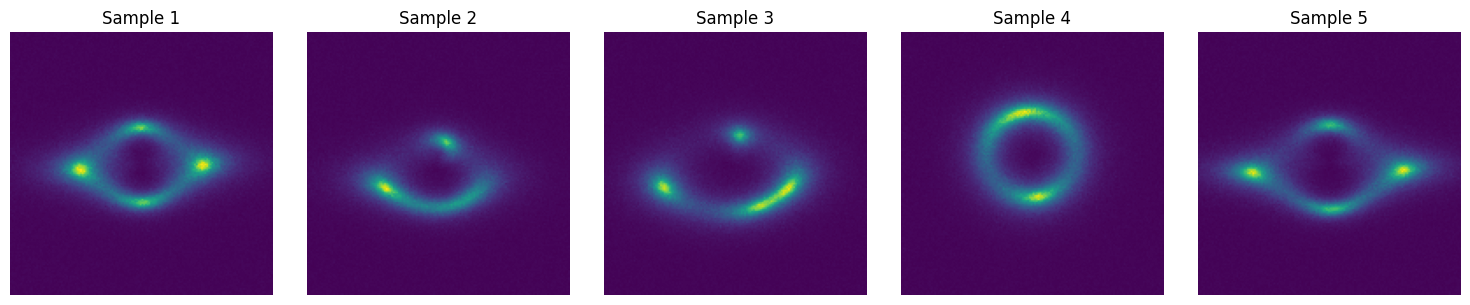

Epoch 1/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.073912, LR: 0.0000499


Epoch 2/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.021120, LR: 0.0000495


Epoch 3/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.012753, LR: 0.0000488


Epoch 4/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.009227, LR: 0.0000479


Epoch 5/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.007908, LR: 0.0000467


Epoch 6/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.006614, LR: 0.0000453


Epoch 7/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.006421, LR: 0.0000437


Epoch 8/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.005739, LR: 0.0000419


Epoch 9/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.005639, LR: 0.0000399


Epoch 10/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.005153, LR: 0.0000378


DDIM Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.005088, LR: 0.0000355


Epoch 12/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.005088, LR: 0.0000331


Epoch 13/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.004564, LR: 0.0000306


Epoch 14/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.004416, LR: 0.0000281


Epoch 15/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.004953, LR: 0.0000255


Epoch 16/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.004683, LR: 0.0000229


Epoch 17/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.016693, LR: 0.0000204


Epoch 18/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.015900, LR: 0.0000179


Epoch 19/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.016134, LR: 0.0000155


Epoch 20/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.015738, LR: 0.0000133


DDIM Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.015129, LR: 0.0000111


Epoch 22/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.014702, LR: 0.0000091


Epoch 23/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.015302, LR: 0.0000073


Epoch 24/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.014774, LR: 0.0000057


Epoch 25/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.015029, LR: 0.0000043


Epoch 26/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.015652, LR: 0.0000031


Epoch 27/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.015884, LR: 0.0000022


Epoch 28/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.014767, LR: 0.0000015


Epoch 29/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.014789, LR: 0.0000011


Epoch 30/30:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.015139, LR: 0.0000010


DDIM Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Generating samples using DDIM sampling (faster)...


DDIM Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

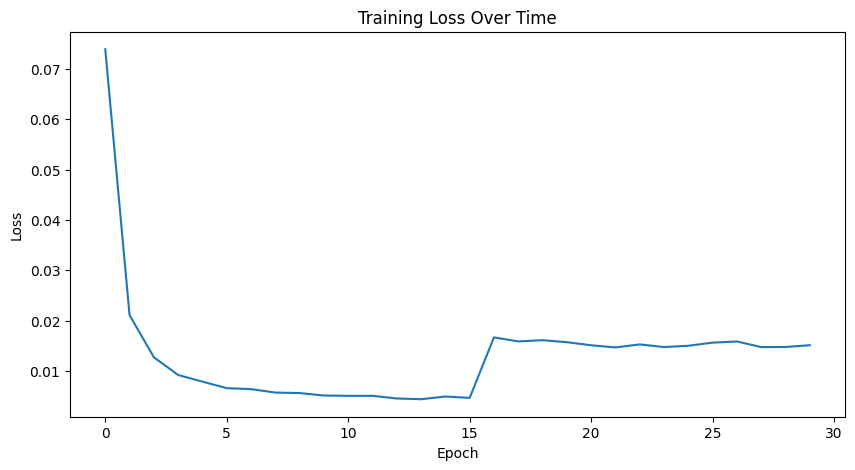

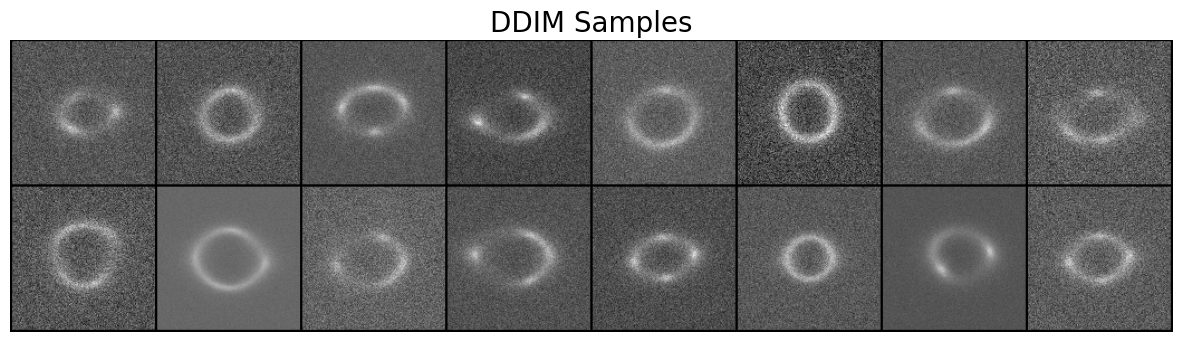

Calculating FID score...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 38.2MB/s]


DDIM Sampling FID: 226.4794


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


DDIM Sampling Inception Score: 1.3638 ± 0.2308

Evaluation Results:
DDIM Sampling FID: 226.4794
DDIM Sampling Inception Score: 1.3638 ± 0.2308


In [43]:
# Run the main pipeline - this executes the entire training and evaluation
results = main()